In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import os
import requests
from sklearn.linear_model import LinearRegression

# 定义代理服务器
proxies = {
    'http': 'http://192.168.123.200:20171',
    'https': 'http://192.168.123.200:20171'
}

# 配置 requests 使用代理
session = requests.Session()
session.proxies.update(proxies)

# 创建一个空的数据框来存储所有数据
all_data = pd.DataFrame()

# 定义股票代码
target_tickers = ["CLSK", "IREN", "WULF", "BTBT","COIN","CORZ","BITF","QQQ"]
base_tickers = ["IBIT", "MAGS"]
tickers = target_tickers + base_tickers
end_time = datetime.now()
start_time = end_time - timedelta(days=30*6)

# 下载数据
data = yf.download(tickers, start=start_time, end=end_time, session=session)['Adj Close']



[*********************100%%**********************]  10 of 10 completed


In [4]:

all_data = data
# 计算每日收益率
returns = data.pct_change().dropna()
from sklearn.linear_model import LinearRegression

# 创建一个空的数据框来存储回归结果
results_df = pd.DataFrame(columns=['Target', 'Intercept'] + base_tickers + ['R_squared', 'Noise Mean', 'Noise Std',"sum_p","mags_pct"])

# 对每个 target_tickers 进行多元回归计算
for target in target_tickers:
    X = returns[base_tickers]
    y = returns[target]

    # 创建并拟合回归模型
    model = LinearRegression().fit(X, y)

    # 获取回归系数和截距
    weights = model.coef_
    intercept = model.intercept_
    r_squared = model.score(X, y)

    # 计算回归残差（噪声）
    predicted_y = model.predict(X)
    noise = y - predicted_y

    # 将结果添加到数据框中
    [base_1,base_2] = list(weights)
    results = [target, intercept] + [base_1,base_2] + [r_squared, noise.mean(), noise.std(),sum([base_1,base_2])*r_squared,base_1-base_2]
    results_df.loc[len(results_df)] = results

# 如果需要在 Jupyter Notebook 中显示数据框
from IPython.display import display
display(results_df)

,Target,Intercept,IBIT,MAGS,R_squared,Noise Mean,Noise Std,sum_p,mags_pct
0,CLSK,0.003426,1.126208,0.745223,0.304741,-9.175397e-19,0.065388,0.570302,0.380985
1,IREN,0.004313,0.690547,1.375789,0.195633,2.408542e-18,0.070550,0.404244,-0.685242
2,WULF,0.008457,0.784140,0.780469,0.162608,1.605694e-18,0.072639,0.254418,0.003671
3,BTBT,-0.000182,0.858738,0.819746,0.234000,2.293849e-19,0.062930,0.392765,0.038992
4,COIN,0.000598,1.004219,0.647377,0.566363,-4.587698e-19,0.033682,0.935404,0.356842
5,CORZ,0.006125,0.658092,0.817957,0.179457,2.064464e-18,0.060360,0.264887,-0.159865
6,BITF,0.000361,0.634249,0.303278,0.164915,-2.293849e-19,0.053320,0.154612,0.330970
7,QQQ,-0.000437,0.024225,0.578558,0.827993,3.584139e-19,0.004102,0.499100,-0.554332


In [5]:
results_dict = results_df.to_dict(orient='records')
results_dict

[{'Target': 'CLSK',
  'Intercept': 0.003425765971350329,
  'IBIT': 1.126208297613911,
  'MAGS': 0.7452231659304627,
  'R_squared': 0.3047408692022079,
  'Noise Mean': -9.175396897728567e-19,
  'Noise Std': 0.0653875839576945,
  'sum_p': 0.5703016508528724,
  'mags_pct': 0.3809851316834483},
 {'Target': 'IREN',
  'Intercept': 0.004312915309348075,
  'IBIT': 0.690547277583348,
  'MAGS': 1.3757890036873344,
  'R_squared': 0.19563342323179989,
  'Noise Mean': 2.4085416856537488e-18,
  'Noise Std': 0.07055045136617567,
  'sum_p': 0.4042444402530509,
  'mags_pct': -0.6852417261039864},
 {'Target': 'WULF',
  'Intercept': 0.008457026034922497,
  'IBIT': 0.7841399876475283,
  'MAGS': 0.7804687305596243,
  'R_squared': 0.1626079848826112,
  'Noise Mean': 1.6056944571024992e-18,
  'Noise Std': 0.07263852223120427,
  'sum_p': 0.25441787079743033,
  'mags_pct': 0.0036712570879040562},
 {'Target': 'BTBT',
  'Intercept': -0.00018205893405886728,
  'IBIT': 0.8587382311465378,
  'MAGS': 0.8197457327631

In [113]:
(results_df.values[4,2]-results_df.values[4,3])/results_df.values[4,2]

IndexError: index 4 is out of bounds for axis 0 with size 0

In [26]:
from scipy import stats

# Calculate daily returns
returns = all_data.pct_change().dropna()

# Define a function to calculate beta
def calculate_beta(stock_returns, market_returns):
    beta, alpha, r_value, p_value, std_err = stats.linregress(market_returns, stock_returns)
    return [beta, alpha, r_value, p_value, std_err]

# Calculate beta for each stock against QQQ and IBIT
beta_results = {}
for stock in ["CLSK", "IREN", "WULF", "BTBT"]:
    beta_qqq = calculate_beta(returns[stock], returns["QQQ"])
    beta_eth = calculate_beta(returns[stock], returns["ETH-USD"])
    beta_btc = calculate_beta(returns[stock], returns["BTC-USD"])
    beta_results[stock] = {"Beta vs QQQ": (beta_qqq[0],beta_qqq[3]), "Beta vs BTC-USD":( beta_btc[0],beta_btc[3]),"Beta vs ETH-USD":( beta_eth[0],beta_eth[3]) }

# Display the beta coefficients
beta_df = pd.DataFrame(beta_results).T

print(beta_df)

                                      Beta vs QQQ  \
CLSK   (2.604997611672954, 0.0006886068854324499)   
IREN   (5.262714735433806, 8.449263098329666e-06)   
WULF  (3.7638778936793744, 0.0031066431507313632)   
BTBT   (3.6423141680265556, 0.009563338802749403)   

                                   Beta vs BTC-USD  \
CLSK   (0.6998099834032947, 0.0024902068315644284)   
IREN     (0.11789098441504334, 0.7584640328603584)   
WULF     (0.4637148350837259, 0.23690603545775835)   
BTBT  (1.4776134036326072, 0.00029644379090698326)   

                                  Beta vs ETH-USD  
CLSK   (0.4259281474309018, 0.004205779174626516)  
IREN   (0.012432245678961746, 0.9596397267036112)  
WULF  (-0.012440522564827649, 0.9607288650586014)  
BTBT   (0.7084638234167662, 0.008308003523288266)  


/tmp/ipykernel_3175307/2559864271.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = all_data.pct_change().dropna()


# 多资产组合回测

[                       0%%                      ]

[*********************100%%**********************]  12 of 12 completed


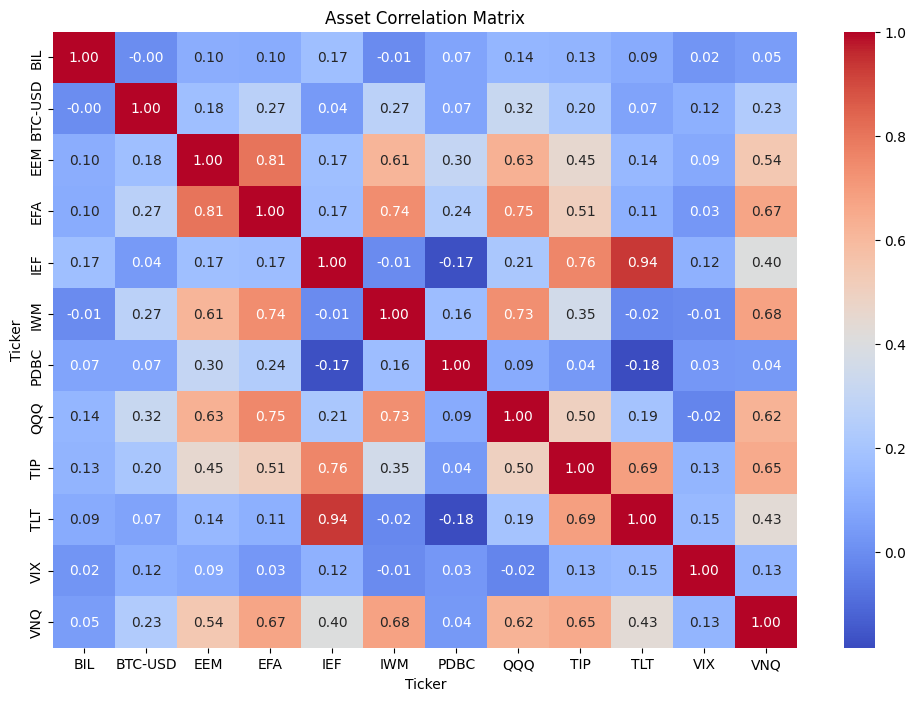

Ticker,BIL,BTC-USD,EEM,EFA,IEF,IWM,PDBC,QQQ,TIP,TLT,VIX,VNQ
Ticker,,,,,,,,,,,,
BIL,1.000000,-0.001931,0.103128,0.100929,0.174674,-0.006440,0.072049,0.138292,0.126523,0.093889,0.023497,0.050402
BTC-USD,-0.001931,1.000000,0.175656,0.265272,0.038807,0.269502,0.071637,0.317840,0.204902,0.066988,0.116367,0.234141
EEM,0.103128,0.175656,1.000000,0.805659,0.172147,0.614672,0.304889,0.629202,0.450518,0.144473,0.089091,0.540685
EFA,0.100929,0.265272,0.805659,1.000000,0.167228,0.739290,0.238098,0.753650,0.505731,0.112430,0.030170,0.667678
IEF,0.174674,0.038807,0.172147,0.167228,1.000000,-0.008417,-0.172345,0.209540,0.758735,0.935051,0.119765,0.404615
IWM,-0.006440,0.269502,0.614672,0.739290,-0.008417,1.000000,0.164585,0.734341,0.354821,-0.015647,-0.005551,0.677654
PDBC,0.072049,0.071637,0.304889,0.238098,-0.172345,0.164585,1.000000,0.094858,0.037153,-0.184205,0.032432,0.035013
QQQ,0.138292,0.317840,0.629202,0.753650,0.209540,0.734341,0.094858,1.000000,0.498420,0.190582,-0.022890,0.621163
TIP,0.126523,0.204902,0.450518,0.505731,0.758735,0.354821,0.037153,0.498420,1.000000,0.685961,0.131941,0.651565


In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import requests
import seaborn as sns

def calculate_correlations(data):
    # 计算资产的日收益率
    returns = data.pct_change().dropna()
    
    # 计算相关性矩阵
    correlation_matrix = returns.corr()
    
    # 绘制相关性矩阵
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Asset Correlation Matrix')
    plt.show()
    
    return correlation_matrix

# 定义代理服务器
proxies = {
    'http': 'http://192.168.123.200:20171',
    'https': 'http://192.168.123.200:20171'
}

# 配置 requests 使用代理
session = requests.Session()
session.proxies.update(proxies)

offensive_tickers = ['IWM', 'EFA', 'EEM', 'VNQ', 'PDBC', 'IEF', 'TLT', 'BIL','QQQ',"BTC-USD"]
base_tickers = ['TIP','VIX']
tickers = base_tickers+offensive_tickers
start_date = (datetime.now() - timedelta(days=365*12)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')
data = yf.download(tickers, start=start_date, end=end_date, interval='1mo', session=session)['Adj Close']
data = data.ffill().bfill()
calculate_correlations(data)

In [11]:
def calculate_momentum(df, periods=[1, 3, 6, 12]):
    momentum = {}
    for period in periods:
        momentum[period] = df.pct_change(period).iloc[-1]
    return momentum

def canary_strategy(data, tickers):
    results = {}
    for ticker in tickers:
        df = data[ticker].dropna()
        momentum = calculate_momentum(df)
        results[ticker] = {
            'momentum': momentum,
            'weighted_average': np.mean(list(momentum.values()))
        }

    # Calculate TIP and VIX momentum
    tip_momentum = results['TIP']['weighted_average']
    vix_momentum = results['VIX']['weighted_average']
    
    decision = {}
    if tip_momentum > 0:  # Optimistic market, low volatility
        positive_momentums = {asset: results[asset]['weighted_average'] for asset in offensive_tickers if results[asset]['weighted_average'] > 0}
        sorted_assets = sorted(positive_momentums, key=positive_momentums.get, reverse=True)[:2]
        if len(sorted_assets) < 2:
            sorted_assets.extend(['IEF' if results['IEF']['weighted_average'] > results['BIL']['weighted_average'] else 'BIL'] * (2 - len(sorted_assets)))
        for asset in sorted_assets:
            decision[asset] = 0.5

    # elif tip_momentum > 0 and vix_momentum > 0:  # Optimistic market, high volatility
    #     decision = {'IEF': 0.5, 'BIL': 0.5}

    else:  # Pessimistic market
        if results['IEF']['weighted_average'] > results['BIL']['weighted_average']:
            decision['IEF'] = 1.0
        else:
            decision['BIL'] = 1.0

    return decision, results


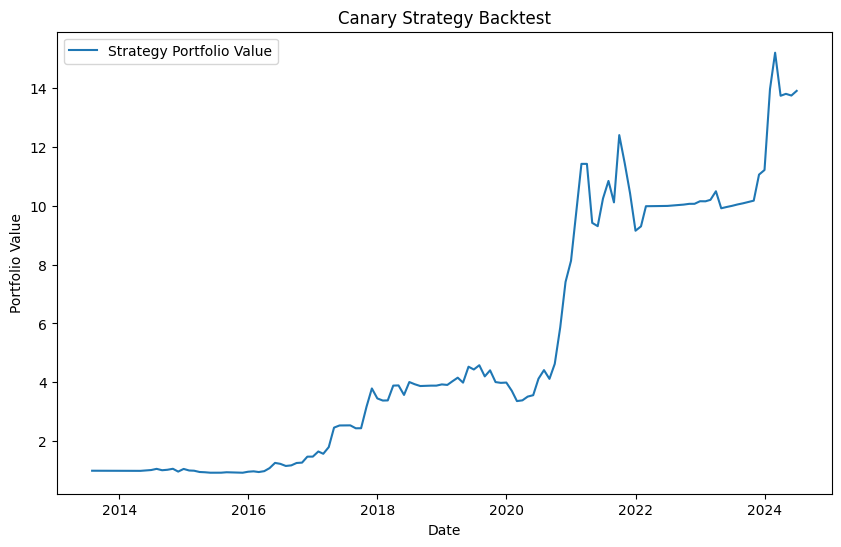

Final portfolio value: 13.89


In [12]:
def backtest_strategy(tickers):
    strategy_history = []
    portfolio_value = 1.0
    portfolio_values = []
    holding_ratios = []

    for i in range(12, len(data)):
        current_data = data.iloc[:i+1]
        
        if i==12:
            returns=0
        else:
            returns = sum([data.iloc[i][asset] / data.iloc[i-1][asset] - 1 for asset in decision.keys()]) / len(decision)
        decision, results = canary_strategy(current_data, tickers)

        portfolio_value *= (1 + returns)
        portfolio_values.append(portfolio_value)
        strategy_history.append({
            'date': data.index[i],
            'decision': decision,
            'portfolio_value': portfolio_value,
            'results': results
        })
        holding_ratios.append(decision)
    
    return strategy_history, portfolio_values, holding_ratios



strategy_history, portfolio_values, holding_ratios = backtest_strategy(tickers)

# Plot portfolio value over time
dates = [entry['date'] for entry in strategy_history]
plt.figure(figsize=(10, 6))
plt.plot(dates, portfolio_values, label='Strategy Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Canary Strategy Backtest')
plt.legend()
plt.show()


# Display final portfolio value
print(f"Final portfolio value: {portfolio_values[-1]:.2f}")

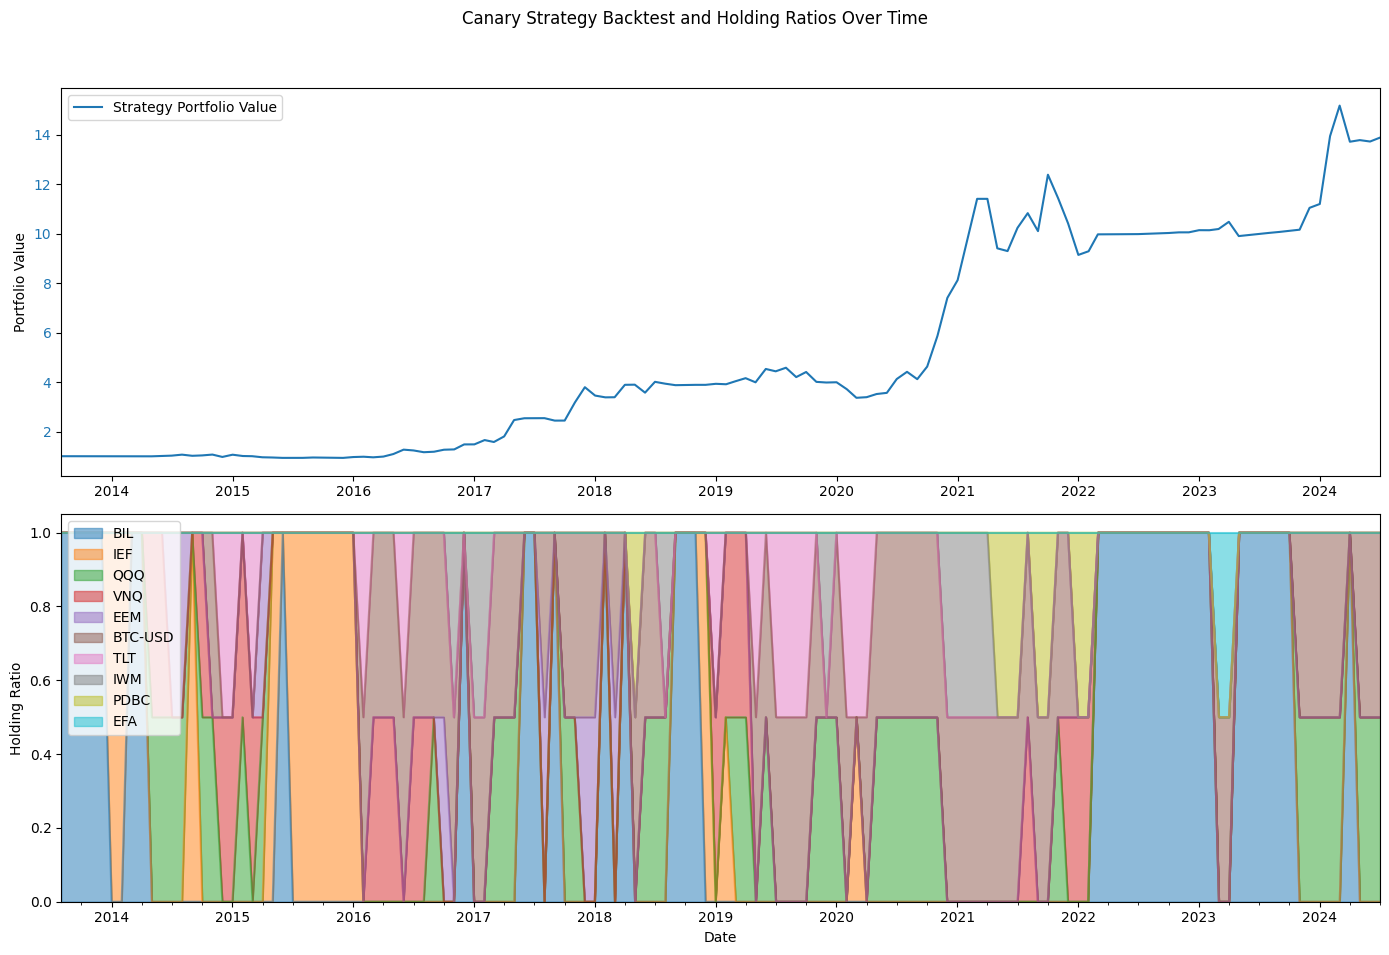

In [13]:
# Prepare data for plotting
dates = [entry['date'] for entry in strategy_history]
holding_df = pd.DataFrame(holding_ratios, index=dates)

# Plot combined chart
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot portfolio value
ax[0].plot(dates, portfolio_values, label='Strategy Portfolio Value', color='tab:blue')
ax[0].set_xlim([min(dates), max(dates)])
ax[0].set_ylabel('Portfolio Value')
ax[0].tick_params(axis='y', labelcolor='tab:blue')
ax[0].legend(loc='upper left')

# Plot holding ratios
holding_df.plot.area(ax=ax[1], stacked=True, alpha=0.5)
ax[1].set_ylabel('Holding Ratio')
ax[1].legend(loc='upper left')

plt.xlabel('Date')
plt.suptitle('Canary Strategy Backtest and Holding Ratios Over Time')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [55]:
holding_ratios[-1]

{'QQQ': 0.5, 'IWM': 0.5}

In [14]:
strategy_history[-1]

{'date': Timestamp('2024-07-01 00:00:00'),
 'decision': {'BTC-USD': 0.5, 'QQQ': 0.5},
 'portfolio_value': 13.89414139854877,
 'results': {'TIP': {'momentum': {1: 0.018477464709375058,
    3: 0.03798177051700269,
    6: 0.015653234395479387,
    12: 0.04107307041283437},
   'weighted_average': 0.028296385008672875},
  'VIX': {'momentum': {1: 0.0, 3: 0.0, 6: 0.0, 12: 0.0},
   'weighted_average': 0.0},
  'IWM': {'momentum': {1: 0.07722609719685791,
    3: 0.11566315802299854,
    6: 0.1360087657590756,
    12: 0.11191620116167744},
   'weighted_average': 0.11020355553515238},
  'EFA': {'momentum': {1: 0.03940425906388434,
    3: 0.053663033764213,
    6: 0.0854091149321432,
    12: 0.10714243490707642},
   'weighted_average': 0.07140471066682924},
  'EEM': {'momentum': {1: 0.020380582805863412,
    3: 0.06021000791071773,
    6: 0.13201380692181064,
    12: 0.055539426082241494},
   'weighted_average': 0.06703595593015832},
  'VNQ': {'momentum': {1: 0.07516422534595613,
    3: 0.131211614